In [88]:
import cv2
import numpy as np
import pandas as pd
import json
from data import findSegments,findBumps,findBoundaries
def coco_data(filelist): #pass a list of filename paths; for each path, take filename as image_id (volID_XXX.png where XXX is scan number) 
    dataset = dict(info = {}, images = [], categories = [{'id':int(0), 'name':'rpd'}],licenses=None, annotations=[] )
    instances = 0
    wrong_poly = 0
    ifiles=0

    for fn in filelist:
        imageid = fn.split("/")[-1]
        if '_' not in imageid:
            imageid = imageid.replace('.tiff','_0.tiff')
        seg = cv2.imread(fn)
        dat = dict(file_name = fn, height = seg.shape[0], width = seg.shape[1], id = imageid)
        dataset['images'].append(dat)
          
        if (np.max(seg) != 0):
            
            seg = seg[:, :, 0]
            ret,binseg = cv2.threshold(seg, 128, 255, cv2.THRESH_BINARY) #sourch seg is grayscale
            
            #integral of segmentation
            y = (binseg/binseg.max()).sum(axis=0).astype(int) 
            df = pd.DataFrame(y,columns=['y'])
            #find and break up segments into instances
            segs = findSegments(df)
            bumps = findBumps(df,segs,thresh=3)
            idx = findBoundaries(df,bumps)
            #insert breaks in image
            for i in idx:
                binseg[:,i]=0
            # if len(idx)>0:
            #     fig,ax = visualize_breakup(im[:,:,0],binseg,segs,bumps,idx)
            #     pdf.savefig(fig)
            #     plt.close(fig)
            
            #find contours and bounding boxes
            #pdb.set_trace()
            contours, hierarchy = cv2.findContours(binseg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for c in contours:
                instances += 1
                x,y,w,h = cv2.boundingRect(c)
                area = cv2.contourArea(c)
                if len(c) < 4: 
                    wrong_poly += 1
                    continue

                anot = dict(
                        image_id = imageid,
                        id = instances+1,
                        bbox = (x,y,w,h),  
                        category_id = 0,
                        area = area,
                        iscrowd=0,
                        segmentation = [c.flatten().tolist()],
                        score = 1.0)
                dataset["annotations"].append(anot)
        
        ifiles=ifiles+1
#             if ii==500:
#                 break
    print(f"Found {len(dataset['images'])} images")
    print(f"Found {instances} instances")
    print(f"Found {wrong_poly} too few vertices")
    return dataset

In [89]:
rootdir = '/data/amd-data/cera-rpddata/Interrater_agreement_outputs'
import glob, os
subdirs = ['Grader 1','Grader 2','Grader 3','Model']
for subdir in subdirs:
    
    files = glob.glob(os.path.join(rootdir,subdir,'*.tiff'),recursive=True)
    # files = [f.replace('.tiff','_0.tiff') for f in files]
    dat = coco_data(files)
    json.dump(dat,open('interrater_annotation_files/'+subdir.strip(' ')+'.json','w'))


Found 280 images
Found 222 instances
Found 0 too few vertices
Found 280 images
Found 922 instances
Found 27 too few vertices
Found 280 images
Found 80 instances
Found 0 too few vertices
Found 280 images
Found 297 instances
Found 1 too few vertices


In [90]:
from evaluate_graders import EvaluateClassGraders
myeval = EvaluateClassGraders(annotation_file_gt='interrater_annotation_files/Grader 3.json',annotation_file_dt='interrater_annotation_files/Grader 2.json',iou_thresh=0.2,prob_thresh=.99)
myeval.evaluate();
myeval.summarize_scalars()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Calculated metrics for 280 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.00s).


{'precision': 0.07286995515695067,
 'precision_ci': (0.05760513760771712, 0.09178583376136693),
 'recall': 0.81,
 'recall_ci': (0.710628902322573, 0.8809628611933906),
 'f1': 0.13371088988216173,
 'f1_ci': (0.10501908465844836, 0.1624026951058751),
 'fpr': 0.44166666666666665,
 'fpr_ci': (0.3802490279953446, 0.5049223291479811),
 'iou': 0.2,
 'probability': 0.99}

In [7]:
import sys
sys.path
if '..' not in sys.path:
    sys.path.append('..')
print(sys.path)
import analysis_lib
tables = analysis_lib.CreatePlotsRPD.initfromcoco(myeval.mycoco,prob_thresh = myeval.prob_thresh)

tables.dfimg

['/data/amd-data/cera-rpd/detectron2-rpd/datasets', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/root/.local/lib/python3.7/site-packages', '..']


,gt_instances,gt_pxs,gt_xpxs,dt_instances,dt_pxs,dt_xpxs,volID,scan
108_0.tiff,1.0,195.0,18.0,25.0,4062.0,611.0,108,0
53_0.tiff,0.0,0.0,0.0,1.0,98.0,16.0,53,0
143_0.tiff,2.0,520.0,44.0,8.0,1883.0,247.0,143,0
18_0.tiff,0.0,0.0,0.0,0.0,0.0,0.0,18,0
206_0.tiff,0.0,0.0,0.0,2.0,140.0,31.0,206,0
...,...,...,...,...,...,...,...,...
208_0.tiff,0.0,0.0,0.0,0.0,0.0,0.0,208,0
243_0.tiff,2.0,505.0,38.0,6.0,688.0,85.0,243,0
5_0.tiff,1.0,163.0,19.0,6.0,900.0,153.0,5,0
106_0.tiff,0.0,0.0,0.0,0.0,0.0,0.0,106,0


In [15]:
from PIL import Image
def image_gen(json_file):
    dataset = json.load(open(json_file,'r'))
    for f in dataset['images']:
        yield Image.open(f['file_name'])

gen = image_gen('interrater_annotation_files/Grader 2.json')


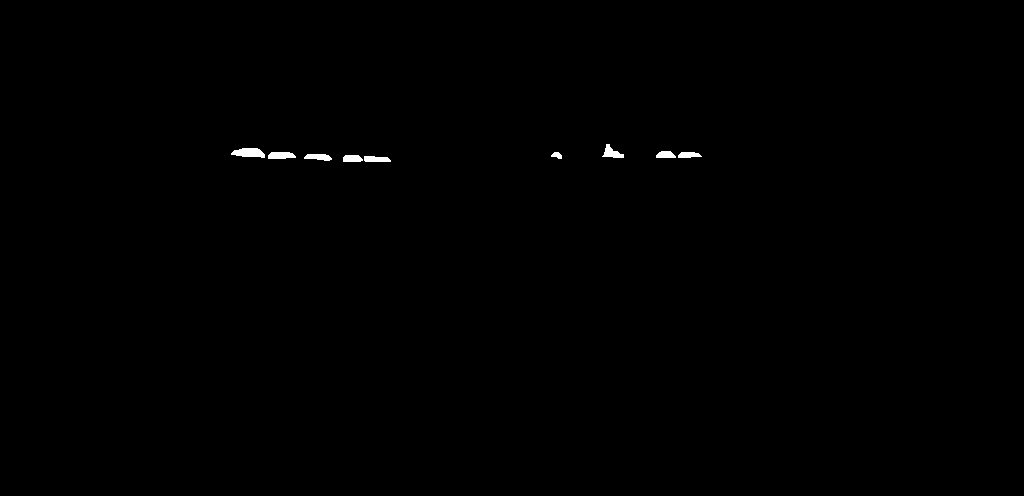

In [87]:
next(gen)

In [14]:
dat['images']

[{'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/236.tiff',
  'height': 496,
  'width': 1024,
  'id': '236_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/17.tiff',
  'height': 496,
  'width': 1024,
  'id': '17_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/173.tiff',
  'height': 496,
  'width': 1024,
  'id': '173_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/138.tiff',
  'height': 496,
  'width': 1024,
  'id': '138_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/84.tiff',
  'height': 496,
  'width': 1024,
  'id': '84_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/109.tiff',
  'height': 496,
  'width': 1024,
  'id': '109_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/142.tiff',
  'height': 496,
  'width': 1024